In [78]:
from __future__ import print_function
from collections import namedtuple
from copy import deepcopy
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import traceback
import time
import yaml

import pydrake  # MUST BE BEFORE TORCH OR PYRO
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')
from multiprocessing.managers import SyncManager
from tensorboardX import SummaryWriter

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_nodes_place_setting import *
from scene_generation.models.probabilistic_scene_grammar_model import *
from scene_generation.models.probabilistic_scene_grammar_fitting import *

In [92]:
seed = int(time.time()) % (2**32-1)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

root_node = TableWithoutPlaceSettings()
hyper_parse_tree = generate_hyperexpanded_parse_tree(root_node)
guide_gvs = hyper_parse_tree.get_global_variable_store()

train_dataset = dataset_utils.ScenesDataset("../../data/table_setting/table_setting_environments_generated_nominal_train")
test_dataset = dataset_utils.ScenesDataset("../../data/table_setting/table_setting_environments_generated_nominal_test")
print("%d training examples" % len(train_dataset))
print("%d test examples" % len(test_dataset))

pyro.get_param_store().load("../../data/table_setting/icra_runs/nominal_lesioned/1/param_store_best_on_test.pyro")

for var_name in guide_gvs.keys():
    guide_gvs[var_name][0] = pyro.param(var_name + "_est",
                                        guide_gvs[var_name][0],
                                        constraint=guide_gvs[var_name][1].support)

100 training examples
100 test examples


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


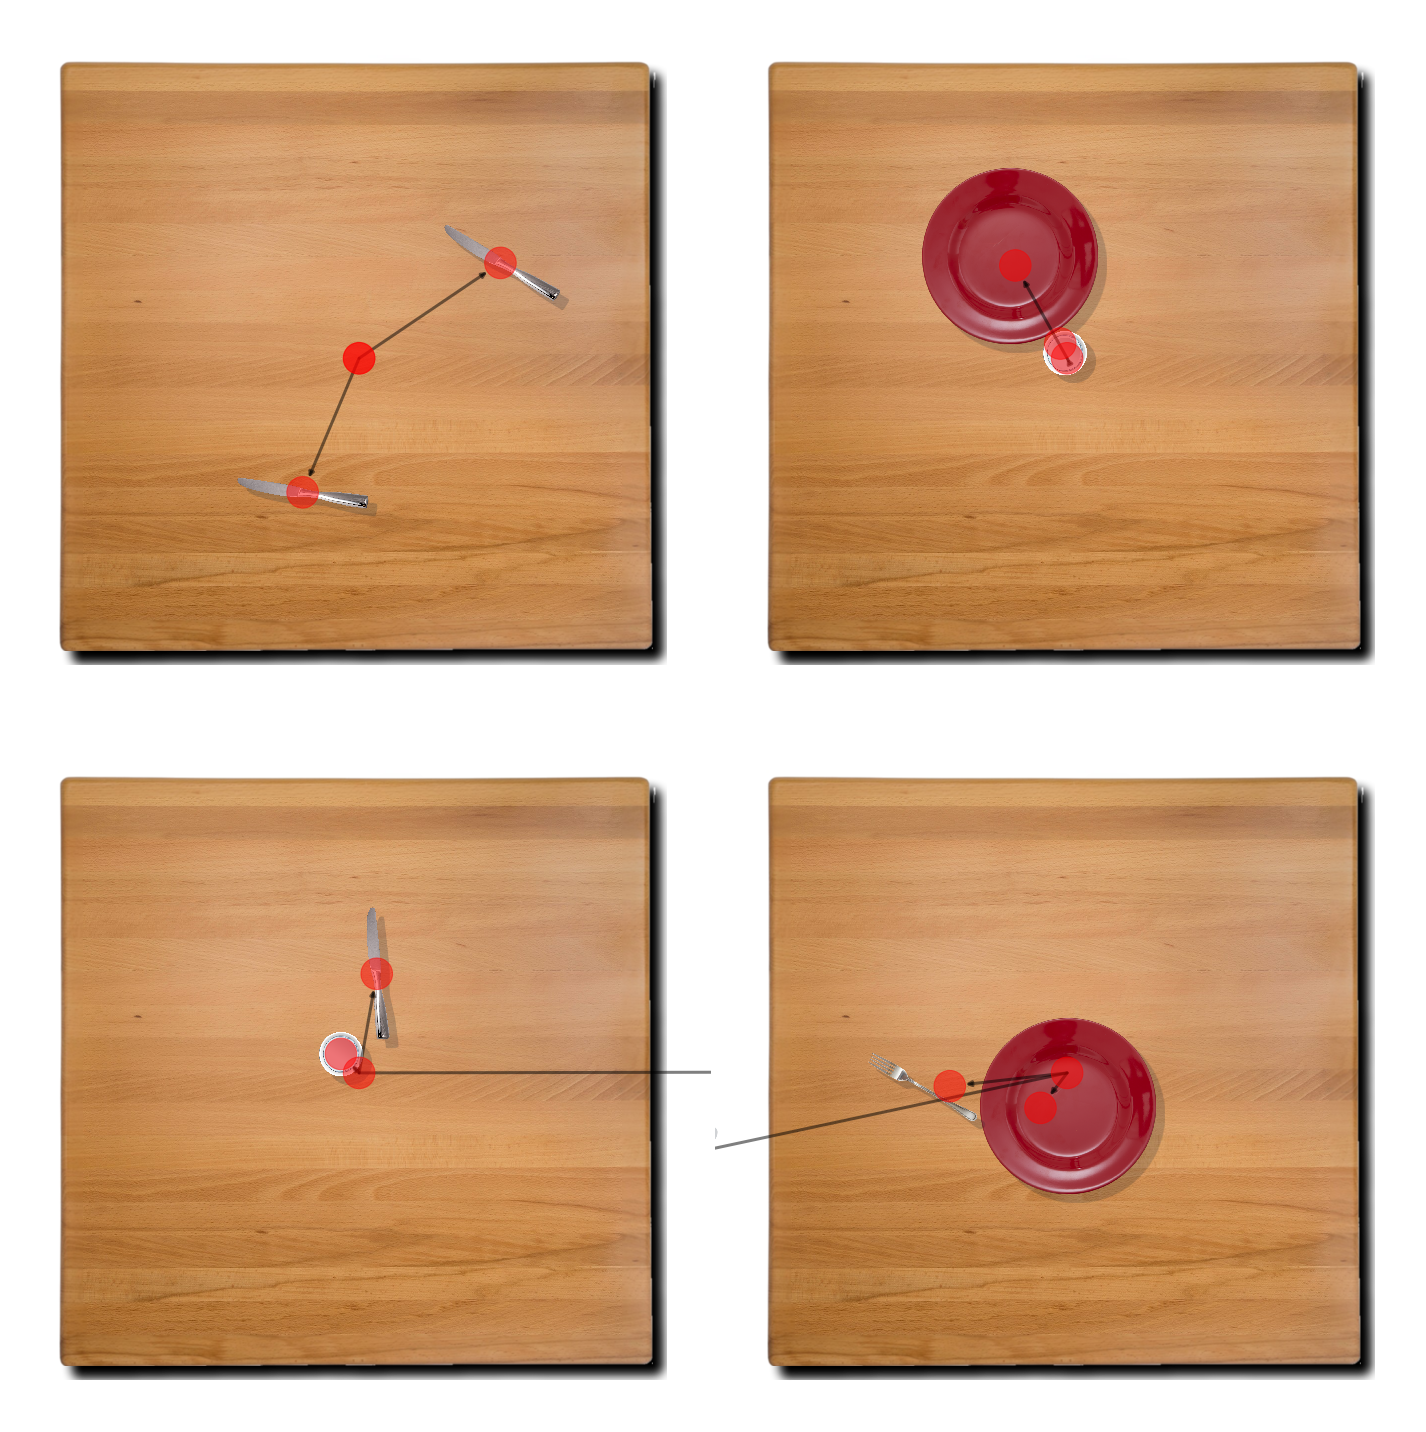

In [93]:
# Generate a grid of sampled feasible environments from the loaded model
plt.figure().set_size_inches(20, 20)
for k in range(4):
    plt.subplot(2, 2, k+1)
    parse_tree = generate_unconditioned_parse_tree(root_node=root_node, initial_gvs=guide_gvs)
    yaml_env = convert_tree_to_yaml_env(parse_tree)
    yaml_env = ProjectEnvironmentToFeasibility(yaml_env, base_environment_type="table_setting",
                                               make_nonpenetrating=True, make_static=False)[-1]
    DrawYamlEnvironmentPlanarForTableSettingPretty(yaml_env, ax=plt.gca(), hide_table=False)
    node_class_to_color_dict = {"Table":[0., 0., 1.], "PlaceSetting":[0., 1., 0.]}        
    draw_parse_tree(parse_tree, label_name=False, label_score=False, color_by_score=False,
                    node_class_to_color_dict=node_class_to_color_dict, alpha=0.5)
    plt.xlim(0.1, 0.9)
    plt.ylim(0.1, 0.9)
plt.tight_layout()

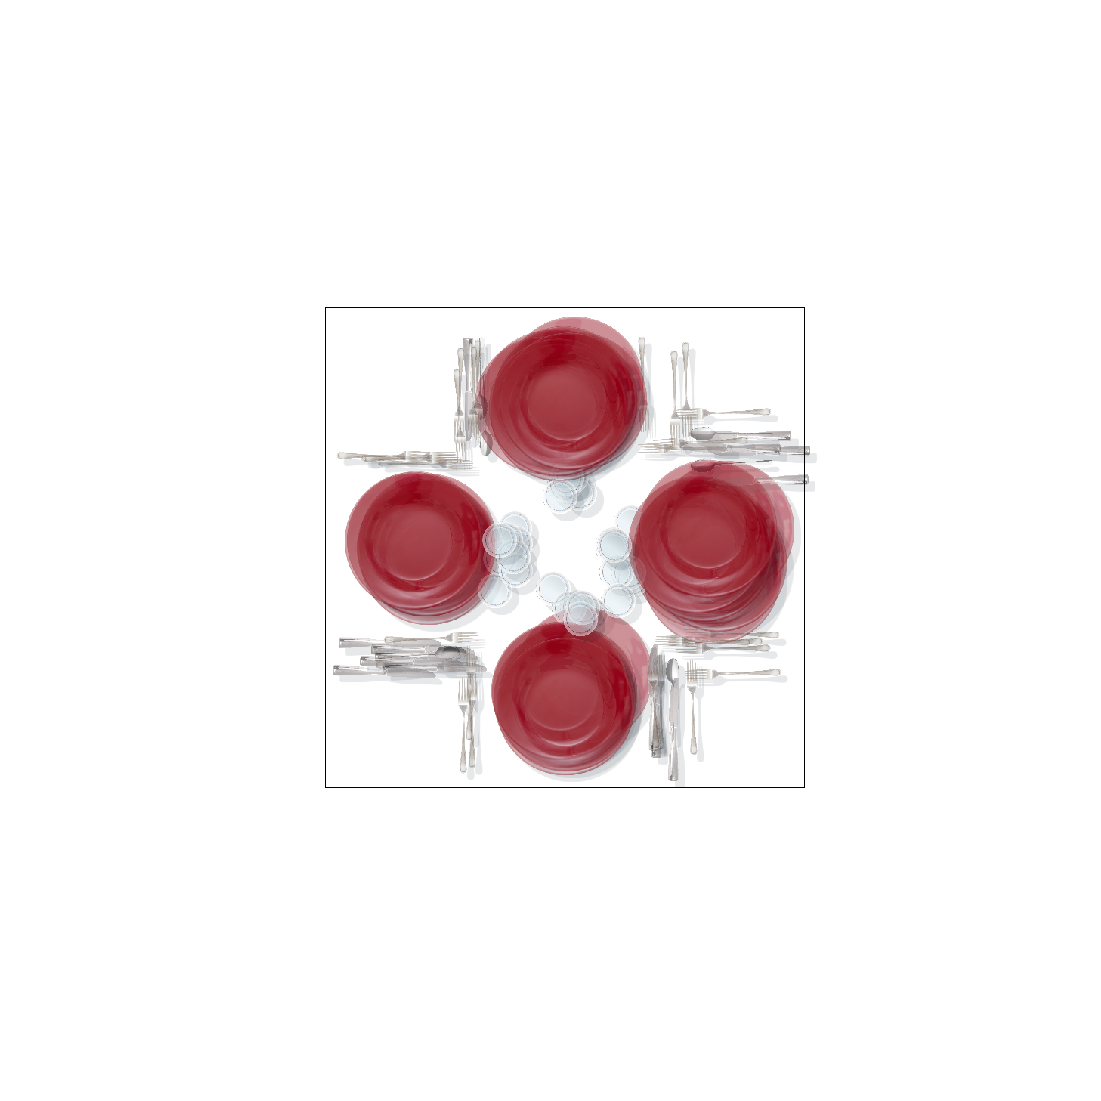

In [95]:
# Illustrate the distribution of generations by drawing lots of samples from it
plt.figure().set_size_inches(20, 20)
images = []
for k in range(20):
    plt.gca().clear()
    #parse_tree = generate_unconditioned_parse_tree(root_node=root_node, initial_gvs=guide_gvs)
    #yaml_env = convert_tree_to_yaml_env(parse_tree)
    yaml_env = test_dataset[k]
    #yaml_env = ProjectEnvironmentToFeasibility(yaml_env, base_environment_type="table_setting", make_nonpenetrating=True, make_static=False)[-1]
    DrawYamlEnvironmentPlanarForTableSettingPretty(yaml_env, ax=plt.gca(), hide_table=True)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    images.append(dataset_utils.fig2data(plt.gcf()).copy())
plt.gca().clear()
for im in images:
    plt.imshow(im, alpha=0.5)
plt.gca().axis('off')
plt.show()

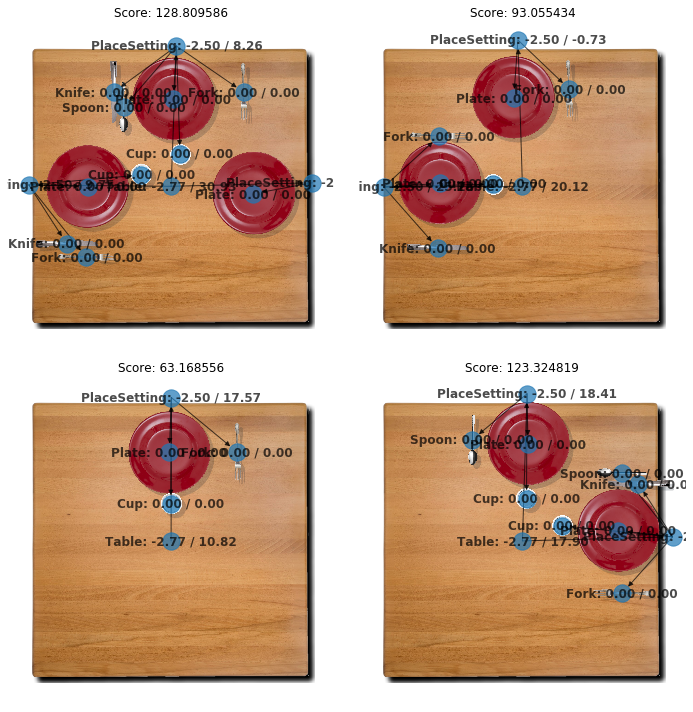

In [33]:
# Parse examples from the test set using the learned params, and draw the parses
plt.figure().set_size_inches(10, 10)
parse_trees = guess_parse_trees_batch_async(test_dataset[:4], guide_gvs=guide_gvs.detach())
for k in range(4):
    plt.subplot(2, 2, k+1)
    DrawYamlEnvironmentPlanarForTableSettingPretty(test_dataset[k], ax=plt.gca())
    draw_parse_tree(parse_trees[k], label_name=True, label_score=True, alpha=0.7)
plt.tight_layout()

# Calculate ELBO (which in the single-parse-tree case is just the probability of the observed nodes):
for parse_tree in parse_trees:
    joint_score = parse_tree.get_total_log_prob()[0]
    latents_score = parse_tree.get_total_log_prob(include_observed=False)[0]
    print("ELBO: ", joint_score - latents_score)

In [40]:
# LONG RUNNING: PARSE EVERY EXAMPLE FROM THE TEST SET
all_test_parse_trees = guess_parse_trees_batch_async(test_dataset, guide_gvs=guide_gvs.detach())

Text(0, 0.5, 'Relative occurance')

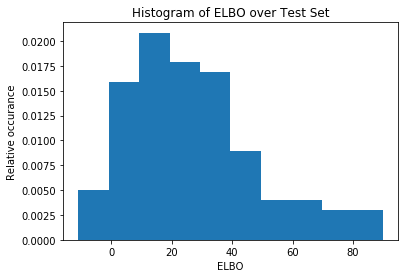

In [54]:
all_test_parse_trees_scores = []
for parse_tree in all_test_parse_trees:
    joint_score = parse_tree.get_total_log_prob()[0]
    latents_score = parse_tree.get_total_log_prob(include_observed=False)[0]
    all_test_parse_trees_scores.append((joint_score - latents_score).item())
order = np.argsort(all_test_parse_trees_scores)
all_test_parse_trees_in_sorted_order = [all_test_parse_trees[x] for x in order]
all_test_parse_trees_scores_in_sorted_order = [all_test_parse_trees_scores[x] for x in order]
plt.hist(all_test_parse_trees_scores, density=True)
plt.title("Histogram of ELBO over Test Set")
plt.xlabel("ELBO")
plt.ylabel("Relative occurance")

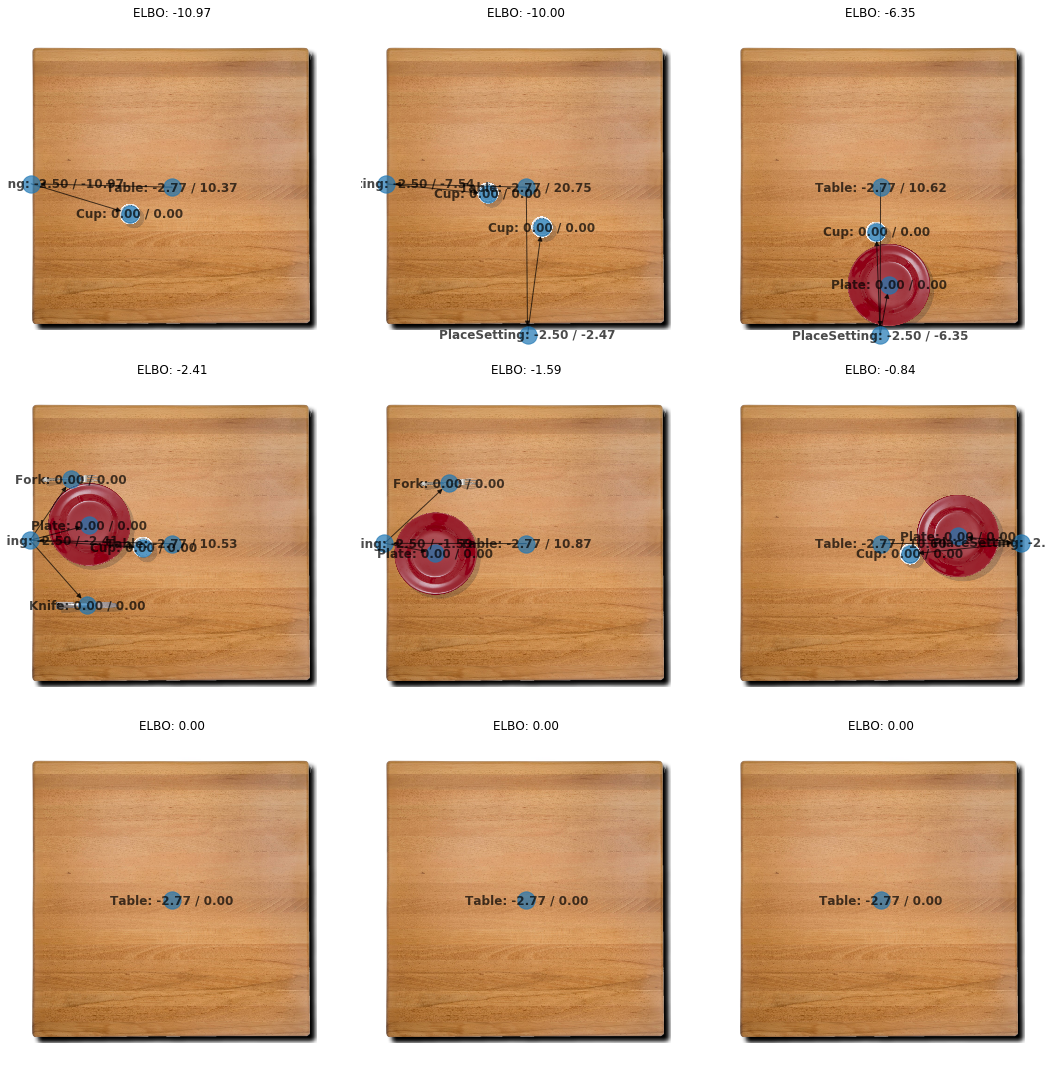

In [50]:
# Parse examples from the test set using the learned params, and draw the parses
plt.figure().set_size_inches(15, 15)
N = 3
for k in range(N**2):
    plt.subplot(N, N, k+1)
    parse_tree = all_test_parse_trees_in_sorted_order[k]
    score = all_test_parse_trees_scores_in_sorted_order[k]
    yaml_env = convert_tree_to_yaml_env(parse_tree)
    DrawYamlEnvironmentPlanarForTableSettingPretty(yaml_env, ax=plt.gca())
    draw_parse_tree(parse_tree, label_name=True, label_score=True, alpha=0.7)
    plt.title("ELBO: %2.2f" % score)
plt.tight_layout()

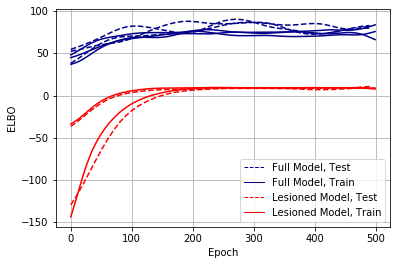

In [133]:
import scipy
import os
from scipy.ndimage import filters

def load_data_from_dir(path):
    runs = os.listdir(path)
    lesioned_runs = []
    full_runs = []
    for run in runs:
        data = np.loadtxt(path + "/" + run, skiprows=1, delimiter=",")
        if "lesioned" in run:
            lesioned_runs.append(data[:, 2])
        else:
            full_runs.append(data[:, 2])
    inds = data[:, 1]
    return inds, np.vstack(full_runs).T, np.vstack(lesioned_runs).T

def apply_filtering(data, sigma):
    return filters.gaussian_filter1d(data, sigma, axis=0, mode='nearest')
        
inds_train, full_runs_train, lesioned_runs_train = load_data_from_dir("run_data/train_elbo")
full_runs_train_smoothed = apply_filtering(full_runs_train, sigma=20.)
lesioned_runs_train_smoothed = apply_filtering(lesioned_runs_train, sigma=20.)
plt.figure().set_size_inches(6, 4)
#plt.plot(full_runs_train, alpha=0.1, color='darkblue', linestyle="--")
plt.plot(full_runs_train_smoothed, color='darkblue', alpha=1.0)
#plt.plot(lesioned_runs_train, alpha=0.1, color='g')
plt.plot(lesioned_runs_train_smoothed, color='red', alpha=1.0)

inds_test, full_runs_test, lesioned_runs_test = load_data_from_dir("run_data/test_elbo")
full_runs_test_smoothed = apply_filtering(full_runs_test, sigma=3.)
lesioned_runs_test_smoothed = apply_filtering(lesioned_runs_test, sigma=3.)
#plt.plot(inds_test, full_runs_test, alpha=0.1, color='darkblue')
plt.plot(inds_test, full_runs_test_smoothed, color='darkblue', linestyle="--", alpha=1.0)
#plt.plot(inds_test, lesioned_runs_test, alpha=0.1, color='lime')
plt.plot(inds_test, lesioned_runs_test_smoothed, color='red', linestyle="--", alpha=1.0)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='darkblue', lw=1, linestyle="--"),
                Line2D([0], [0], color='darkblue', lw=1, linestyle="-"),
                Line2D([0], [0], color='red', lw=1, linestyle="--"),
                Line2D([0], [0], color='red', lw=1, linestyle="-")]

plt.grid(True)
plt.ylabel("ELBO")
plt.xlabel("Epoch")
plt.gca().legend(custom_lines, ['Full Model, Test', 'Full Model, Train', 'Lesioned Model, Test', 'Lesioned Model, Train'])

Nominal:  [0.15 0.12 0.  ] [0.02 0.02 0.02]



[]

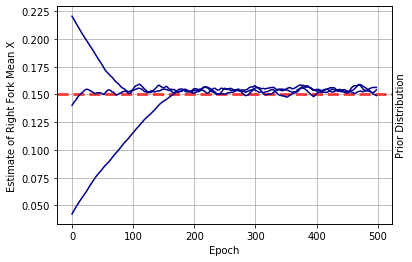

In [139]:
# Get nominal
pyro.clear_param_store()
pyro.get_param_store().load("../../data/table_setting/place_setting_nominal_param_store.pyro")
right_fork_mean_nominal = pyro.param("place_setting_right_fork_mean_est").detach().numpy()
right_fork_var_nominal = pyro.param("place_setting_right_fork_var_est").detach().numpy()

print("Nominal: ", right_fork_mean_nominal, right_fork_var_nominal)

def load_normal_model_data_from_dir(path):
    runs = os.listdir(path)
    lesioned_runs = []
    full_runs = []
    for run in runs:
        data = np.loadtxt(path + "/" + run, skiprows=1, delimiter=",")
        full_runs.append(data[:, 2])
    inds = data[:, 1]
    print()
    data_len = min([len(run) for run in full_runs])
    full_runs = [run[:data_len] for run in full_runs]
    return inds, np.vstack(full_runs).T

inds_train, right_fork_mean_x = load_normal_model_data_from_dir("run_data/right_fork_mean_x")
data = apply_filtering(right_fork_mean_x, sigma=1.)
plt.figure().set_size_inches(6, 4)
plt.axhline(y=right_fork_mean_nominal[0], xmin=0, xmax=1., linestyle="--", color="red", linewidth=3., alpha=0.7)
plt.plot(right_fork_mean_x, color='darkblue')
plt.grid(True)
plt.ylabel("Estimate of Right Fork Mean X")
plt.xlabel("Epoch")

# Prior is 0.15 mean, 0.05 var
x = np.linspace(0.05, 0.225, 100.)
y = 
ax2 = plt.gca().twinx()
color = 'tab:blue'
ax2.set_ylabel('Prior Distribution')
ax2.set_yticks([])